## Importing libraries

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib
from matplotlib.gridspec import GridSpec

## Generate a problem

**Generate n samples from $N(0,1)$**

In [2]:
n = 2000
x = np.random.randn(n)
x.sort()
fx = stats.norm.pdf(x)

**Generate m samples from $N(0, \sqrt(2))$**

In [3]:
m = 1000
y = 2. * np.random.randn(m)
y.sort()
fy = stats.norm.pdf(y, 0., 2.)

**Distributions of $X$ and $Y$**

In [4]:
def plot_dist(x, fx, y, fy):
    fig, axis = plt.subplots()
    axis.plot(x, fx, color = "darkblue", label = "$x$")
    axis.plot(y, fy, color = "darkred", label = "$y$")
    plt.legend()
    plt.show()

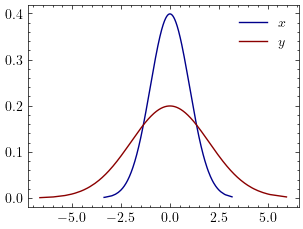

In [5]:
plot_dist(x, fx, y, fy)

**Discretize $x \sim X$ and $y \sim Y$**

In [6]:
# Discretize x using the histogram
# returns the normalized histogram and the lower limits of the intervals
def discretize(x, nbins, normalize = True):
    freq, inter = np.histogram(x, nbins)
    inter = inter[:-1]
    freq = freq.astype(np.float32)
    width = inter[1] - inter[0]
    n = x.size
    if normalize:
        freq /= (width * n)
    return freq, inter

In [7]:
N = 15
M = 15

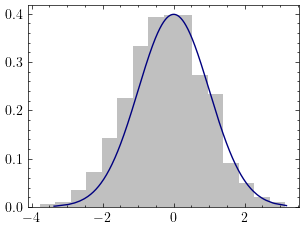

In [8]:
freq_x, inter_x = discretize(x, N)
plt.bar(inter_x, freq_x, color = "silver")
plt.plot(x, fx, color = "navy")
plt.show()

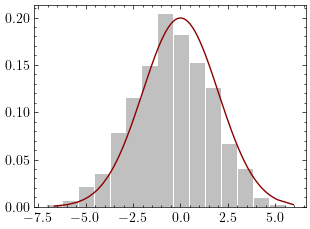

In [9]:
freq_y, inter_y = discretize(y, M)
plt.bar(inter_y, freq_y, color = "silver")
plt.plot(y, fy, color = "darkred")
plt.show()

**Distributions of $X$ and $Y$**

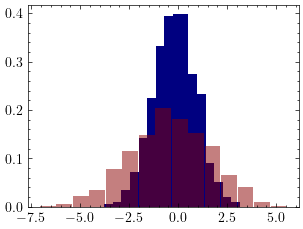

In [10]:
plt.bar(inter_x, freq_x, color = "navy")
plt.bar(inter_y, freq_y, color = "darkred", alpha = 0.5)
plt.show()

## Discrete optimal transport as a linear program

**Discrete probability measures**

Let $X$ and $Y$ be two discrete measures in the probability spaces $(\Omega_{X}, F_{X}, \mu)$ and $(\Omega_{Y}, F_{Y}, \nu)$.

<font color="blue">$$\mu(x) = \sum_{z \in \Omega_{X}} \mu(z) I_{x}(z)$$</color>

The measure of the set x is the sum of the measures of all the $z \in \Omega_{X}$ such that $z \in x$.

similarly

<font color="blue">$$\nu(y) = \sum_{z \in \Omega_{Y}} \nu(z) I_{y}(z)$$</font>

with

<font color="blue">$$\sum_{x \in \Omega_{X}} \mu(x) = 1$$</font>

and

<font color="blue">$$\sum_{y \in \Omega_{Y}} \nu(y) = 1$$</font>

**Optimal transport for discrete distributions**

the optimal transport problem for discrete distributions is
<font color="blue">
$$
\begin{align}
\text{min} \big\{ \sum_{X\text{x}Y}c_{T}(x,y) \gamma(x,y) : \gamma(x,y) \in \Gamma(x,y) \big\}
\end{align}
$$
</font>

If $X$ is defined in $\Omega_{X} = [1, 2, \ldots N]$ and $Y$ is defined in $\Omega_{Y} = [1,2, \ldots, M]$. We note $\mu_i$ the mass of i in $(\Omega_{X}, F_{X}, \mu)$ and $\nu_{i}$ the mass of i in $(\Omega_{Y}, F_{Y}, \nu)$.

The optimal transport problem from $X$ to $Y$ is

$$
\begin{align}
\text{min} \big\{ \sum_{1 \leq i \leq n, 1 \leq j \leq m}c_{i, j} \gamma_{i,j} : \gamma \in \Gamma(X,Y) \big\}
\end{align}
$$

This can be rewritten as

$$
\begin{align}
\text{min} \big\{ \sum_{1 \leq i \leq n, 1 \leq j \leq m}(C \circ \gamma)_{i,j} \big\}
\end{align}
$$

where $\circ$ is the hadamard product.

Let note vec the operation of vectorizing a matrix by stacking its row vectors.
If vec$(C)$ is the vectorization of $C$ and vec$(\gamma)$ is the vectorization of $\gamma$ then we have

$$
\begin{align}
\text{min} \big\{ < \text{vec}(C), \text{vec}(\gamma)> : \Sigma_{j=1}^{n}\gamma_{i,j} = \mu_{i}\text{, and } \Sigma_{i=1}^{n}\gamma_{i,j} = \nu_{j} \big\}
\end{align}
$$

where $<,>$ is the dot product.

let $z$ = vec$(\gamma)$ and $c$ = vec$(C)$

$$
\begin{align}
\text{min} \big\{ <c, z> : \Sigma_{j=1}^{m}\gamma_{i,j} = \mu_{i}\text{, and } \Sigma_{i=1}^{n}\gamma_{i,j} = \nu_{j} \big\}
\end{align}
$$

$$
\begin{array}{cc}
(I_{M} \otimes 1_{1\text{x}N})z & = &
\left[\begin{array}{c c c c c}
[1 \ldots 1] & &              & & & \\
             & \ddots              & & & \\
             & & [1 \ldots 1] & & & \\
             & &              & \ddots & \\
             & &              & & [1 \ldots 1] \\
\end{array}\right]
\left[\begin{array}{c}
z_{1,1} \\
\vdots  \\
z_{1,N} \\
\vdots  \\
z_{i,1} \\
\vdots  \\
z_{i,N} \\
\vdots  \\
z_{M,1} \\
\vdots  \\
z_{M,N} \\
\end{array}\right]\\
 & = & \left[\begin{array}{c}
          \Sigma_{j=1}^{N}z_{1,j}\\
          \vdots \\
          \Sigma_{j=1}^{N}z_{i,j}\\
          \vdots \\
          \Sigma_{j=1}^{N}z_{M,j}\\
       \end{array}\right]\\
 & = & \mu\\
\end{array}
$$

where $\otimes$ is the kronecker product, and

$$
\begin{array}{cc}
(1_{1\text{x}M} \otimes I_{N})z & = &
\left[\begin{array}{c c c c c}
\left[\begin{array}{ccc}
1 &        &  \\
  & \ddots & \\
  &        & 1\\
\end{array}\right]
& \cdots &
\left[\begin{array}{ccc}
1 &        &  \\
  & \ddots & \\
  &        & 1\\
\end{array}\right]
& \cdots &
\left[\begin{array}{ccc}
1 &        &  \\
  & \ddots & \\
  &        & 1\\
\end{array}\right]
\end{array}\right]
\left[\begin{array}{c}
z_{1,1} \\
\vdots  \\
z_{1,N} \\
\vdots  \\
z_{i,1} \\
\vdots  \\
z_{i,N} \\
\vdots  \\
z_{M,1} \\
\vdots  \\
z_{M,N} \\
\end{array}\right]\\
 & = & \left[\begin{array}{c}
          \Sigma_{i=1}^{N}z_{i,1}\\
          \vdots \\
          \Sigma_{i=1}^{N}z_{i,j}\\
          \vdots \\
          \Sigma_{i=1}^{N}z_{i,M}\\
       \end{array}\right]\\
 & = & \nu\\
\end{array}
$$

So we have

$$(I_{M} \otimes 1_{1\text{x}N})z = \mu$$

and

$$(1_{1\text{x}M} \otimes I_{N})z = \nu$$

In matrix form, we have
$$
\begin{array}{ccc}
\left[
\begin{array}{c}
I_{m} \otimes 1_{1\text{x}n}\\
1_{1\text{x}m} \otimes I_{n}
\end{array}
\right]
z
& = &
\left[
    \begin{array}{c}
        \mu\\
        \nu
    \end{array}
\right]
\end{array}
$$

Let's note $A = \left[
\begin{array}{c}
I_{m} \otimes 1_{1\text{x}n}\\
1_{1\text{x}m} \otimes I_{n}
\end{array}
\right]$
and $b=\left[\begin{array}{c}\mu\\ \nu \end{array}\right]$

The equation above becomes $Az=b$

Thereforce the following optimal transport problem
$$
\begin{align}
\text{min} \big\{ <c, z> : z \geq 0, Az = b\big\}
\end{align}
$$

can be reduced to a linear program
<font color="blue">
$$
\begin{align}
\text{min} \big\{ <c, z> : z \geq 0, Az \leq b\big\}
\end{align}
$$
</font>

## Numerical experiments

let $\mu$ be the distribution (histogram) of $X$ and $\nu$ be the distribution (histogram) of $Y$

In [11]:
mu = freq_x
nu = freq_y

**Forming the matrix b**

In [12]:
b = np.concatenate((nu, mu))
b.shape

(30,)

**Forming the matrix A**

In [13]:
Amu = np.kron(np.identity(M), np.ones(N))
Amu.shape

(15, 225)

In [14]:
Anu = np.kron(np.ones(M), np.identity(N))
Anu.shape

(15, 225)

In [15]:
A = np.concatenate((Amu, Anu), 0)
A.shape

(30, 225)

**Solving the linear programming problem using CVXPY**

The variable z is the vectorized transportation matrix $\gamma$.

In [16]:
z = cp.Variable(M * N)

The loss function is the mean squared error

In [17]:
obj = cp.Minimize(cp.sum_squares(A @ z - b))

$z$ is the vectorized coupling of $\mu$ and $\nu$ must be positive.

In [18]:
constraints = [z >= 0]

In [19]:
problem = cp.Problem(obj, constraints)

In [20]:
res = problem.solve()

The minimum risk (mean squared error) is 

In [21]:
res

0.043719123610624105

Let's reshape z back to a matrix of size M x N

In [22]:
Z = z.value.reshape(M, N)

the map of $\mu$ by the transportation map $T$ is $T(\mu) = \sum_{j} \gamma_{ij}$. It should be as close as possible to the target distribution $\nu$.

In [23]:
tmu = Z.sum(1)
tmu.shape

(15,)

## Visual checking

The optimal transport map between $\mu$ and $\nu$

In [24]:
def plot_map(filename = ""):
    fig = plt.figure(figsize=(4, 4))
    gs = GridSpec(2, 2, width_ratios=[1, 4], height_ratios=[1, 4])
    ax1 = plt.subplot(gs[1])
    ax1.bar(range(M), nu, color = "darkred")
    ax1.axis("off")
    ax2 = plt.subplot(gs[2])
    ax2.barh(range(N), mu, color = "navy")
    ax2.invert_xaxis()
    ax2.axis("off")
    ax3 = plt.subplot(gs[3])
    ax3.imshow(Z.transpose())#, interpolation="bilinear")
    ax3.axis("off")
    if filename != "":
        plt.savefig(filename)
    ax1.set_title("Joint and marginal histograms")
    plt.show()

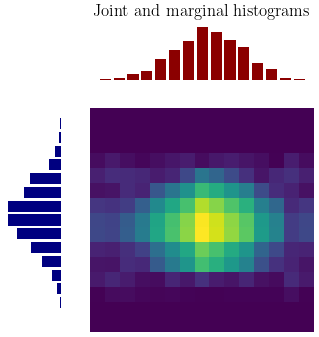

In [25]:
plot_map("../_figures/joint and marginal histograms")

The target distribution $\nu$ and the optimal transport map of $\mu$

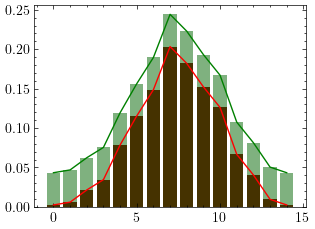

In [26]:
plt.bar(range(M), nu, color = "darkred")
plt.bar(range(M), tmu, color = "darkgreen", alpha = 0.5)
plt.plot(nu, color = "red")
plt.plot(tmu, color = "green")
plt.show()

$T(\mu)$ and $\nu$ have the same shape. Let's draw them side by side.

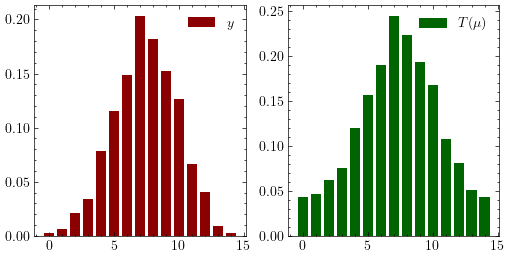

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (6, 3))
axes[0].bar(range(M), nu, color = "darkred", label = "$y$")
axes[0].legend()
axes[1].bar(range(M), tmu, color = "darkgreen", label = "$T(\mu)$")
axes[1].legend()
plt.show()